<h1> метод Монте-Карло </h1>

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # для красивых графиков 
!pip install pertdist
from pert import PERT # для beta - PERT распределения

In [161]:
# np.random.seed(42)

### Построение логнормального распределения для величины PD
**np.lognormal(mean, sigma, size)**
буду пользоваться этой формулой, но нужно учитывать, что на вход она берет mean и sigma для нормального распределения, 
поэтому нужно вспомнить матстат (~~Википедию~~ лекции Палыча....) и выразить из этой формулы  для логнормального распределения математическое ожидание нормального:
$$
\text{PD\_mean} = e^{\mu + \frac{\sigma^2}{2}}
$$



$$
\mu = \ln\left(\text{PD\_mean}\right) - \frac{\sigma^2}{2}
$$

(~~https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5~~)

In [162]:
mean = lambda a, s: np.log(a) - s**2/2

также делаем для стандартного отклонения, НО нужно учитывать, что в формуле будет использоваться уже "исправленное"(нормальное, а не логнормальное) мат. ожидание 

$$
\text{ PD\_sigma } = \sqrt{(e^{\sigma^2} - 1) e ^ { 2\mu + \sigma ^ 2}} = \sqrt{( e ^ {\sigma^2} - 1) {\text {PD\_mean}^ 2}}
$$

$$
\sigma = \sqrt{\ln\left(1 + \frac{\text{ PD\_sigma }^2}{\text{PD\_mean}^2}\right)}
$$


In [164]:
sigma = lambda a, s: np.sqrt(np.log(1 + (s**2 / a**2))) 

In [168]:
def lognormal_loan_data(PD_mean, PD_sigma, n = 50000):
    s = sigma(PD_mean, PD_sigma)
    m = mean(PD_mean, s) # тут как раз исправленное стандартное отклонение
        
    return np.random.lognormal( 
        mean = m,
        sigma = s,
        size = n # кол-во повторений 
    )  

In [165]:
PD_Loan_A = lognormal_loan_data(0.02, 0.007)
PD_Loan_B = lognormal_loan_data(0.01, 0.005)
PD_Loan_C = lognormal_loan_data(0.015, 0.01)

In [166]:
PD_Loan_A

array([0.01377948, 0.0155813 , 0.01612961, ..., 0.01526331, 0.01696387,
       0.02763147])

## Бета-Перт распределение для величины LGD
**плотность распределения:**

$$
f_X(x) = \frac{1}{\mathrm{B}(\alpha, \beta)} x^{\alpha - 1} (1 - x)^{\beta - 1}
$$

выражать ничего не нужно, воспользуюссь готовой библиотекой

In [147]:
def beta_pert_loan_data(LGD_mode, LGD_min = 0, LGD_max = 1, n = 50000):
    return PERT(0, LGD_mode, 1).rvs(n)

Найдем распределения для кредитов 

Expected Losses = Exposure at Default x Probability of Default x Loss Given Default

In [150]:
EAD_A = 1000
EAD_B = 2000
EAD_C = 2500

In [151]:
type(EAD_A)

int

In [152]:
LGD_A = beta_pert_loan_data(0.2)
LGD_B = beta_pert_loan_data(0.3)
LGD_C = beta_pert_loan_data(0.4)

In [153]:
type(LGD_A)

numpy.ndarray

In [154]:
EL_A =  EAD_A * PD_Loan_A * LGD_A
EL_B =  EAD_B * PD_Loan_B * LGD_B
EL_C =  EAD_C * PD_Loan_C * LGD_C
EL = EL_A + EL_B + EL_C

In [155]:
EL

array([13.17248136,  9.64584476, 31.04848516, ..., 32.757483  ,
       50.69255816, 20.24160193])

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

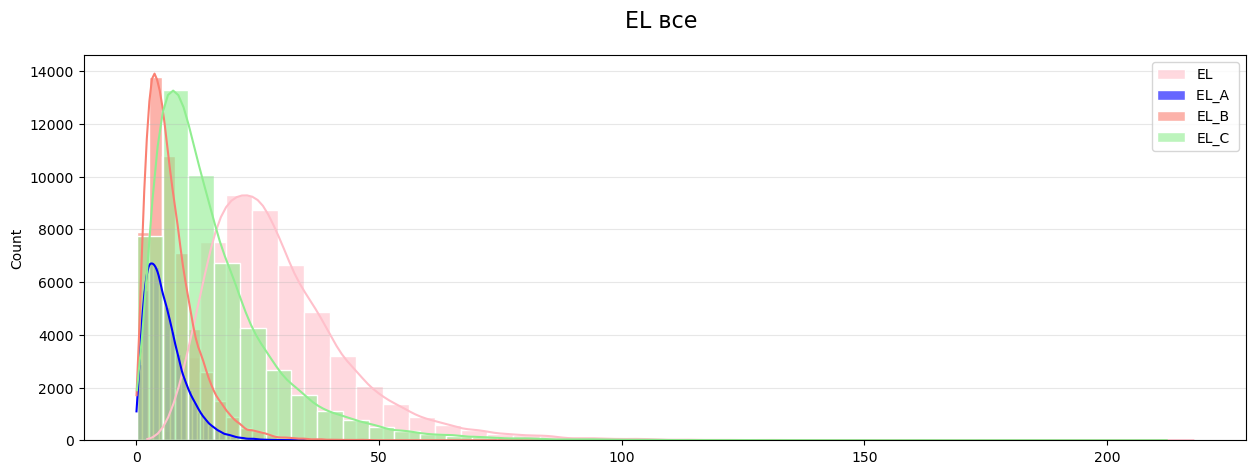

In [207]:
plt.figure(figsize=(15, 5))


hist_kwargs = {
    'bins': 40,
    'kde': True,
    'alpha': 0.6,  
    'edgecolor': 'white',
    'linewidth': 1
}
sns.histplot(EL, color='pink', label='EL', **hist_kwargs)

sns.histplot(EL_A, color='blue', label='EL_A ', **hist_kwargs)
sns.histplot(EL_B, color='salmon', label='EL_B', **hist_kwargs)
sns.histplot(EL_C, color='lightgreen', label='EL_C', **hist_kwargs)
             
plt.title('EL все ', fontsize=16, pad=20)

plt.legend()

plt.grid(axis='y', alpha=0.3)

plt.show()

## Медиана , Среднее и 95 перцентиль 


In [199]:
EL_Quantile = np.quantile(EL, 0.95)
EL_Quantile

57.580820106271325

In [200]:
EL_Median = np.median(EL)
EL_Median

26.505215620498518

In [201]:
EL_Mean = np.mean(EL)
EL_Mean

29.61863371247417

## Визуализируем наш конечный результат

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


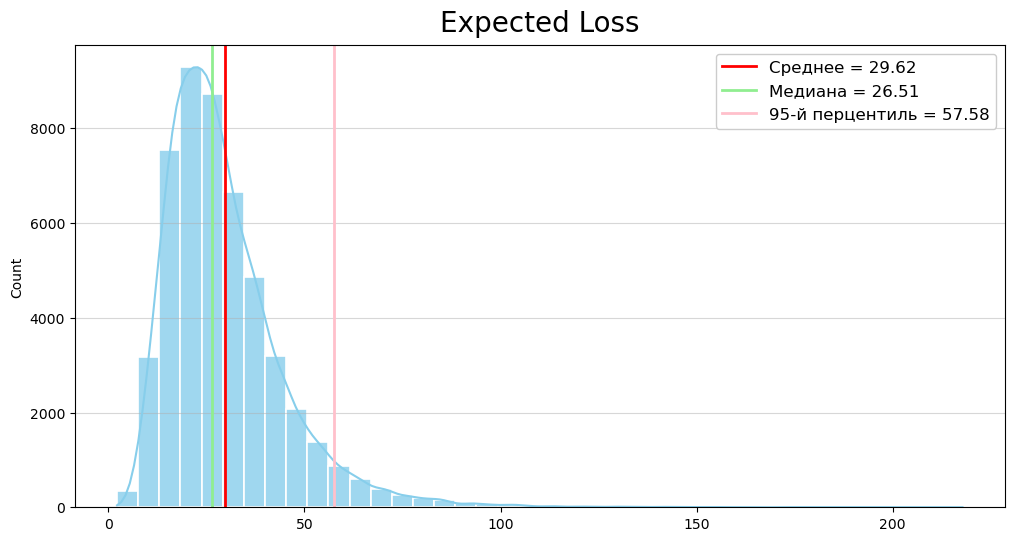

In [202]:
plt.figure(figsize=(12, 6))

ax = sns.histplot(EL, bins=40,
                  kde=True,
                  color='skyblue', 
                  edgecolor='white',
                  linewidth=1.2,
                  alpha=0.8)

plt.axvline(EL_Mean, color='red', linestyle='-', linewidth=2, label=f'Среднее = {EL_Mean:.2f}')
plt.axvline(EL_Median, color='lightgreen', linestyle='-', linewidth=2, label=f'Медиана = {EL_Median:.2f}')
plt.axvline(EL_Quantile, color='pink', linestyle='-', linewidth=2, label=f'95-й перцентиль = {EL_Quantile:.2f}')

plt.title('Expected Loss',
          fontsize=20,
          pad=10)

plt.legend(fontsize=12, framealpha=1)

plt.grid(axis='y', alpha=0.5)


plt.show()